/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


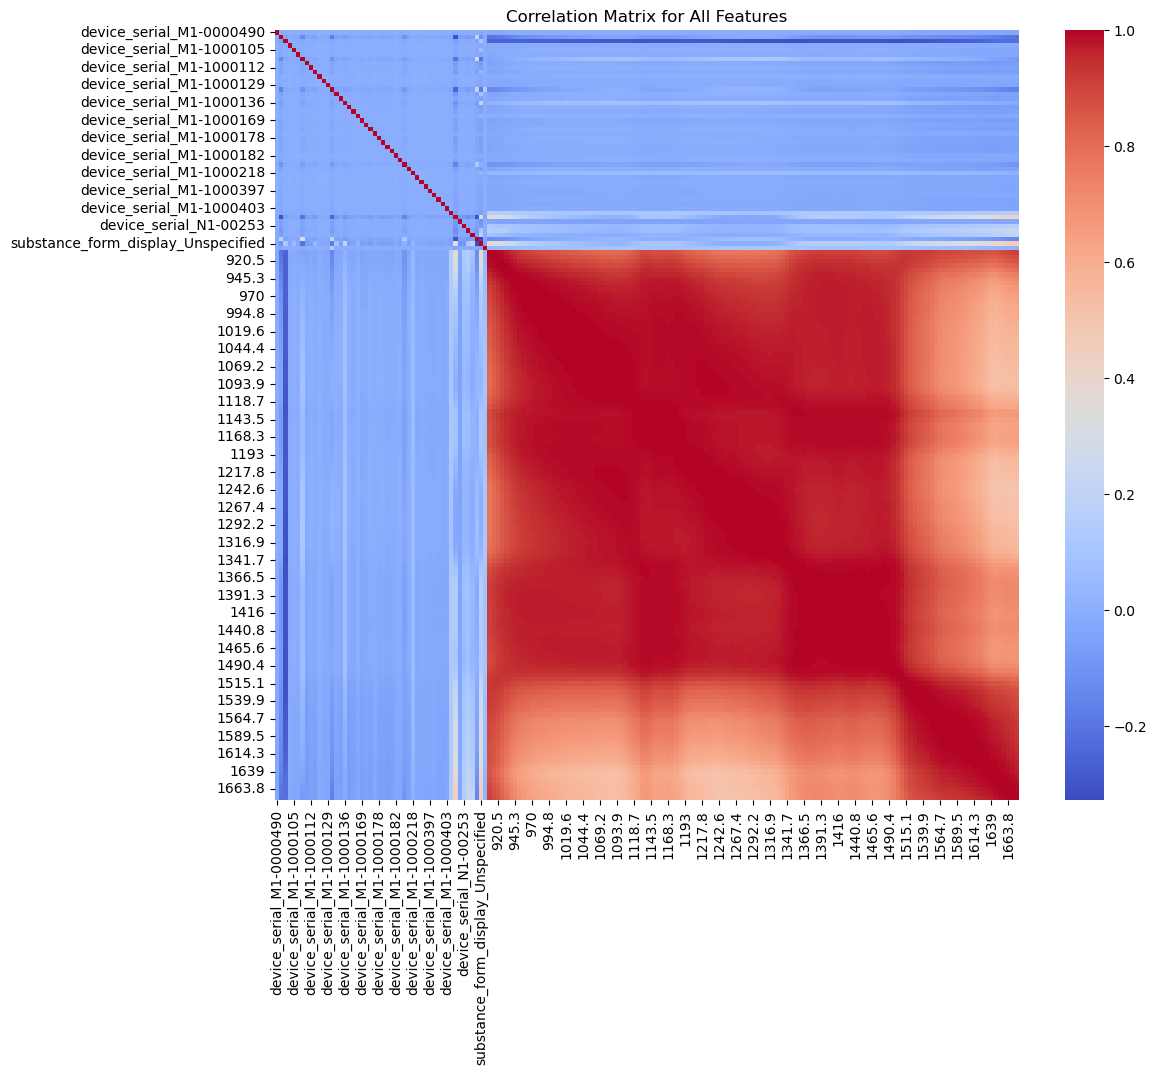

Number of features before removing highly correlated features: 175
Number of features after removing highly correlated features: 126
Selected 38 features using Random Forest with threshold 0.0048.


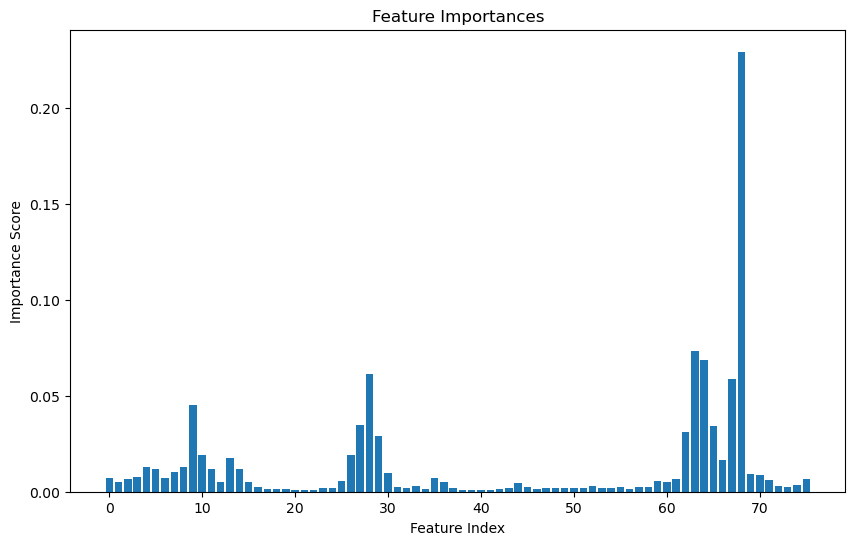

Shape of OG train data: (1300, 131)
Shape of OG test data: (608, 130)
Shape of train data: (1300, 89)
Shape of test data: (608, 89)
Shape of y_train: (1300,)
Submission file saved successfully.
Submission file saved successfully.


/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.56495e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.71341e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.57285e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.53391e-17): result may not be accurate.
  return linalg.s

Best accuracy: -28.13404296634373
Best parameters: {'polynomial__degree': 2, 'regression__alpha': 0.001}
Training MSE: 5.20131043611104
CV MSE: 28.13404296634373
Submission file saved successfully.


In [ ]:

# def knn():
# PURITY log transform  
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import BayesianRidge
from bayes_opt import BayesianOptimization
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm 
from scipy.stats import chi2

def remove_outliers_mahalanobis(data, threshold=0.99):
    """
    Remove multivariate outliers using Mahalanobis distance.
    
    Parameters:
    - data: DataFrame of numeric features.
    - threshold: Chi-squared threshold for outlier removal (default 0.99).
    
    Returns:
    - DataFrame without outliers.
    """
    cov_matrix = np.cov(data, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    mean_vec = data.mean(axis=0)
    
    def mahalanobis(x):
        diff = x - mean_vec
        return np.sqrt(diff.T @ inv_cov_matrix @ diff)
    
    mahalanobis_distances = data.apply(mahalanobis, axis=1)
    chi2_threshold = chi2.ppf(threshold, df=data.shape[1])
    non_outliers = mahalanobis_distances <= np.sqrt(chi2_threshold)
    
    return data[non_outliers].reset_index(drop=True)
    
def preprocessing_v1(apply_one_hot=False, apply_scaling=False, apply_pca=False, apply_correlation=False, apply_remove_outliers=False, apply_variance_threshold=False, apply_random_forest=False):
    train_data_og = pd.read_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/train.csv')
    test_data_og = pd.read_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/test.csv')
    train_data = train_data_og.copy()
    test_data = test_data_og.copy()
    train_data = train_data.drop(columns=['prod_substance'])
    test_data = test_data.drop(columns=['prod_substance'])
    
    non_wavelength_cols = ['device_serial', 'substance_form_display', 'measure_type_display']
    wavelength_cols = train_data.columns[5:]
    
    # Remove NaN values
    train_data = train_data.dropna()
    test_data = test_data.dropna()
    
    if apply_one_hot:
        # One Hot encoding 
        encoder = OneHotEncoder(drop='first',sparse_output=False, handle_unknown='ignore')
        X_train_encoded = encoder.fit_transform(train_data[non_wavelength_cols])
        X_test_encoded = encoder.transform(test_data[non_wavelength_cols])
        
        # Convert encoded features to DataFrame
        X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(non_wavelength_cols))
        X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(non_wavelength_cols))
        
        train_data_combined = pd.concat([pd.DataFrame(X_train_encoded_df), train_data[wavelength_cols].reset_index(drop=True)], axis=1)
        test_data_combined = pd.concat([pd.DataFrame(X_test_encoded_df), test_data[wavelength_cols].reset_index(drop=True)], axis=1)
    else:
        train_data_combined = train_data
        test_data_combined = test_data  
        
    if apply_remove_outliers:
        
        non_outlier_indices = remove_outliers_mahalanobis(train_data_combined[wavelength_cols]).index
        train_data_combined = train_data_combined.loc[non_outlier_indices].reset_index(drop=True)
        print(f"After Mahalanobis outlier removal, train data shape: {train_data_combined.shape}") 
            
    if apply_scaling:
         # Standardisers
        train_data_std = StandardScaler().fit(train_data_combined[wavelength_cols].values)

        # Standardise the data
        wavelength_train_scaled, wavelength_test_scaled = map(
            lambda data, std_mach: std_mach.transform(data),
            [
                train_data_combined[wavelength_cols].values,
                test_data_combined[wavelength_cols].values,
            ],
            [train_data_std, train_data_std],
        )     
        
        train_data_combined[wavelength_cols] = pd.DataFrame(wavelength_train_scaled, columns=wavelength_cols)
        test_data_combined[wavelength_cols] = pd.DataFrame(wavelength_test_scaled, columns=wavelength_cols)   
        
    if apply_pca:
        # Perform PCA on scaled wavelength columns
        pca = PCA(n_components=5)
        wavelength_cols = train_data_combined.columns[54:]
        
        X_train_pca = pca.fit_transform(train_data_combined[wavelength_cols])
        X_test_pca = pca.transform(test_data_combined[wavelength_cols])

        # Combine PCA components with original data
        X_train_combined = pd.concat([train_data_combined.iloc[:, :54].reset_index(drop=True), 
                                      pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(5)])], axis=1)
        X_test_combined = pd.concat([test_data_combined.iloc[:, :54].reset_index(drop=True), 
                                     pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(5)])], axis=1)
        
        train_data_combined = X_train_combined
        test_data_combined = X_test_combined
        
    """ if apply_random_forest:
        # Apply Random Forest for feature selection
        wavelength_cols = train_data_combined.columns[50:] 
        rf = RandomForestRegressor(n_estimators=300, random_state=42)
        y_train = train_data['PURITY'].iloc[train_data_combined.index]
        rf.fit(train_data_combined[wavelength_cols], y_train)
        
        # Select features based on importance
        selector = SelectFromModel(rf, threshold="mean", prefit=True)
        train_data_combined = pd.DataFrame(selector.transform(train_data_combined[wavelength_cols]), 
                                           columns=train_data_combined[wavelength_cols].columns[selector.get_support()])
        test_data_combined = pd.DataFrame(selector.transform(test_data_combined[wavelength_cols]), 
                                          columns=test_data_combined[wavelength_cols].columns[selector.get_support()])
        print(f"Shape after Random Forest feature selection: {train_data_combined.shape}")  """
    
    if apply_variance_threshold:
        # Apply VarianceThreshold
        selector = VarianceThreshold(threshold=0.05)
        train_data_combined = pd.DataFrame(selector.fit_transform(train_data_combined), columns=train_data_combined.columns[selector.get_support(indices=True)])
        test_data_combined = pd.DataFrame(selector.transform(test_data_combined), columns=test_data_combined.columns[selector.get_support(indices=True)])
        print(f"Shape after VarianceThreshold: {train_data_combined.shape}")
    
    #Aussi tester Random forest à la placde de correlation matrix
    if apply_correlation:
    # Compute correlation matrix only for wavelength columns
        #wavelength_cols = train_data_combined.columns[50:] 
        #correlation_matrix = train_data_combined[wavelength_cols].corr()
        correlation_matrix = train_data_combined.corr()

        # Visualize correlation matrix
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
        plt.title("Correlation Matrix for All Features")
        plt.show()

        # Identify highly correlated features (e.g., |r| > 0.999)
        threshold_high = 0.9999

        print(f"Number of features before removing highly correlated features: {train_data_combined.shape[1]}")
        
        high_corr_pairs = [
            (i, j)
            for i in range(correlation_matrix.shape[0])
            for j in range(i + 1, correlation_matrix.shape[1])
            if abs(correlation_matrix.iloc[i, j]) > threshold_high
        ]
        
        features_to_drop = set()
        for i, j in high_corr_pairs:
            features_to_drop.add(correlation_matrix.columns[j])  # Arbitrarily drop the second feature in the pair

        # Remove the selected features
        train_data_combined = train_data_combined.drop(columns=list(features_to_drop))
        test_data_combined = test_data_combined.drop(columns=list(features_to_drop))
        
        #wavelength_cols = train_data_combined.columns[50:]
        
        print(f"Number of features after removing highly correlated features: {train_data_combined.shape[1]}")
        """ print("Highly correlated features:")
        for i, j in high_corr_pairs:
            print(f"{correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]}") """
        
    if apply_random_forest:
        
        wavelength_cols = train_data_combined.columns[50:]
        X_train_rf = train_data_combined[wavelength_cols]
        y_train_rf = train_data['PURITY'].iloc[train_data_combined.index].squeeze()

        # Create and train random forest model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train_rf, y_train_rf)

        # Perform feature selection using the specified threshold
        sfm = SelectFromModel(rf_model, threshold=0.0048, prefit=True)
        selected_features = sfm.get_support()
        selected_feature_names = X_train_rf.columns[selected_features]

        # Apply feature selection to train and test data
        train_data_selected = train_data_combined[selected_feature_names]
        test_data_selected = test_data_combined[selected_feature_names]

        # Add back non-wavelength columns if needed
        non_wavelength_cols = [col for col in train_data_combined.columns if col not in wavelength_cols]
        train_data_combined = pd.concat([train_data_combined[non_wavelength_cols], train_data_selected], axis=1)
        test_data_combined = pd.concat([test_data_combined[non_wavelength_cols], test_data_selected], axis=1)

        print(f"Selected {len(selected_feature_names)} features using Random Forest with threshold {0.0048}.")

        # Evaluate feature importances
        feature_importances = rf_model.feature_importances_

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(feature_importances)), feature_importances)
        plt.title("Feature Importances")
        plt.xlabel("Feature Index")
        plt.ylabel("Importance Score")
        plt.show()

        """ # Test different thresholds
        thresholds = [0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.0048, 0.005, 0.0052]
        cross_val_scores = []

        for threshold in thresholds:
            # Select features based on threshold
            sfm = SelectFromModel(rf_model, threshold=threshold, prefit=True)
            selected_features = sfm.get_support()
            selected_feature_names = X_train_rf.columns[selected_features]

            # Subset the dataset
            X_train_selected = X_train_rf[selected_feature_names]

            # Compute cross-validation scores
            scores = cross_val_score(rf_model, X_train_selected, y_train_rf, cv=5, scoring='r2')
            mean_score = scores.mean()
            cross_val_scores.append(mean_score)

            print(f"Threshold: {threshold}")
            print(f"Number of selected features: {len(selected_feature_names)}")
            print(f"Cross-validated R^2 score: {mean_score:.4f}")

        # Plot cross-validated R^2 scores vs. thresholds
        plt.figure(figsize=(8, 5))
        plt.plot(thresholds, cross_val_scores, marker='o')
        plt.title("Cross-Validated R^2 Score vs. Threshold")
        plt.xlabel("Threshold")
        plt.ylabel("Mean R^2 Score")
        plt.grid()
        plt.show() """


        """ # we obtain the names of the unwanted features
        dropped_feature_names = X_train_rf.columns[feature_indices]
        
        train_data_combined = train_data_combined.drop(columns=dropped_feature_names)
        test_data_combined = test_data_combined.drop(columns=dropped_feature_names) """

            
    # Add sample_name column back to the combined DataFrames
    train_data_combined.insert(0, 'sample_name', train_data_og['sample_name'])
    test_data_combined.insert(0, 'sample_name', test_data_og['sample_name'])
    y_train = train_data['PURITY'].iloc[train_data_combined.index]

    print(f"Shape of OG train data: {train_data_og.shape}")
    print(f"Shape of OG test data: {test_data_og.shape}")
    print(f"Shape of train data: {train_data_combined.shape}")
    print(f"Shape of test data: {test_data_combined.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    
    train_data_combined.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/train_data_combined.csv', index=False)
    print('Submission file saved successfully.')
    test_data_combined.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/test_data_combined.csv', index=False)
    print('Submission file saved successfully.')
            
    return train_data_combined, test_data_combined, y_train


def best_param_RF():
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'random_state': [42]
    }

    # Initialize the RandomForestRegressor
    rf = RandomForestRegressor()

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Preprocess the data
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_scaling=True, apply_remove_outliers=True)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_rf = grid_search.best_estimator_
    print("Best parameters:", grid_search.best_params_)
    return best_rf

    
# Alice tu peux refaire ca en plus beau please (c'est pour voir quel treshold  mettre pour la variance) 
def plot_variance():
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_scaling=True, apply_remove_outliers=True)
    
    # Select only numerical columns
    numerical_cols = X_train.select_dtypes(include=[np.number]).columns
    
    # Calculate variance for each numerical feature
    variance = X_train[numerical_cols].var()
    
    # Plot variance for each feature
    plt.figure(figsize=(10, 6))
    sns.barplot(x=variance, y=variance.index)
    plt.title('Variance of Features')
    plt.xlabel('Variance')
    plt.ylabel('Feature')
    plt.show()

def plot_response_variable(apply_y_transformation=False):
    
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_scaling=True, apply_remove_outliers=True)

    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
        
    plt.figure(figsize=(10, 6))
    sns.histplot(y_train, kde=True)
    plt.title('Distribution of Response Variable (PURITY)')
    plt.xlabel('PURITY')
    plt.ylabel('Frequency')
    plt.xlim(0, 10)
    plt.show()

def apply_log_transformation(y):
    return np.log(y)

def plot_boxplot(title, ax=None):
    """
    Function to calculate summary statistics and plot a boxplot for numeric columns in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing the dataset.
    - col_name: string, the column name of the feature to inspect.
    - title: string, the title of the plot.
    - ax: matplotlib axis object, allows the plot to be part of a larger figure.
    """
    
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_scaling=True, apply_remove_outliers=True)

    # Drop missing values
    non_nan_series = y_train.dropna()
    
    # Calculate summary statistics
    print(y_train.describe())
    
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(y_train):
        
        # Plot boxplot for numeric data
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        ax.boxplot(non_nan_series, vert=False)
        ax.set_title(title)
        ax.set_xlabel('PURITY')
        ax.grid(True)
        
        # Show plot if standalone
        if ax is None:
            plt.show()
    else:
        print(f'PURITY is not a numeric column. Skipping boxplot.\n')
 

def calculate_feature_importance(X_train, y_train, X_test, threshold=0.25):
    # Calculate feature importance using a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Print feature importance
    feature_importance = pd.Series(model.coef_, index=X_train.columns)
    feature_importance = feature_importance.abs().sort_values(ascending=False)
    wavelength_feature_importance_df = feature_importance.reset_index()
    wavelength_feature_importance_df.columns = ['Feature', 'Importance']
    wavelength_feature_importance_df.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/feature_importance_LR1.csv', index=False)
    print('Feature Importance saved successfully.')
    
    # Calculate stats threshold
    threshold_value = feature_importance.quantile(threshold)
    
    # Identify low-importance features
    low_importance_features = feature_importance[feature_importance < threshold_value].index
    print(f'Low importance features: {low_importance_features}')
    
    # Remove low-importance features
    X_train_reduced = X_train.drop(columns=low_importance_features)
    X_test_reduced = X_test.drop(columns=low_importance_features)
    
    return X_train_reduced, X_test_reduced

def submission_file(y_test_predicted):
    submission_reduced = pd.DataFrame({
        'ID': range(1, len(y_test_predicted) + 1),
        'PURITY': y_test_predicted
    })
    return submission_reduced


def linear_regression(feature_importance=False, apply_y_transformation=False):
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_correlation=True, apply_scaling=True, apply_remove_outliers=True)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if feature_importance:
        X_train, X_test = calculate_feature_importance(X_train, y_train, X_test)
        
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = model.predict(X_test)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Save submission to CSV
    submission.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/sample_submission_LR.csv', index=False)
    print('Submission file saved successfully.')

def polynomial_regression(apply_y_transformation=False):
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_correlation=True, apply_scaling=True, apply_remove_outliers=True)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
    
    # Define the pipeline
    pipeline = Pipeline([
        ("polynomial", PolynomialFeatures()),
        ("regression", LinearRegression())
    ])
    
    # Define the parameter grid
    param_grid = {
        "polynomial__degree": np.arange(1, 2, 1)
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, 
                               scoring='neg_mean_squared_error', 
                               return_train_score=True)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best accuracy:", grid_search.best_score_)
    print("Best parameters:", grid_search.best_params_)
    
    # Predict on training data
    y_train_pred = best_model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = best_model.predict(X_test)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Save submission to CSV
    submission.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/sample_submission_POLY_2.csv', index=False)
    print('Submission file saved successfully.')
    
def ridge_regression(apply_y_transformation=False):
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_scaling=True, apply_remove_outliers=False, apply_correlation=True, apply_variance_threshold=False, apply_random_forest=True)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
        
    # Define the pipeline
    pipeline = Pipeline([
        ("polynomial", PolynomialFeatures()),
        ("regression", Ridge())
    ])
    
    # Define the parameter grid
    param_grid = {
        "polynomial__degree": np.arange(1, 3, 1),
        "regression__alpha": np.logspace(-12,-3,10)
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, 
                               scoring='neg_mean_squared_error', 
                               return_train_score=True)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best accuracy:", grid_search.best_score_)
    print("Best parameters:", grid_search.best_params_)
    
    # Predict on training data
    y_train_pred = best_model.predict(X_train)
    if apply_y_transformation:
        y_train_pred = np.exp(y_train_pred)
        y_train_original = np.exp(y_train)
        mse = mean_squared_error(y_train_original, y_train_pred)
    else:
        mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = best_model.predict(X_test)
    if apply_y_transformation:
        y_test_pred = np.exp(y_test_pred)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Save submission to CSV
    submission.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/sample_submission_RIDGE.csv', index=False)
    print('Submission file saved successfully.')
    
def lasso_regression(apply_y_transformation=False):
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_correlation=True, apply_scaling=True, apply_remove_outliers=True)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
        
    # Define the pipeline
    pipeline = Pipeline([
        ("polynomial", PolynomialFeatures()),
        ("regression", Lasso())
    ])
    
    # Define the parameter grid
    param_grid = {
        "polynomial__degree": np.arange(1, 3, 1),
        "regression__alpha": np.logspace(-12, -3, 10)
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, 
                               scoring='neg_mean_squared_error', 
                               return_train_score=True)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best accuracy:", grid_search.best_score_)
    print("Best parameters:", grid_search.best_params_)
    
    # Predict on training data
    y_train_pred = best_model.predict(X_train)
    if apply_y_transformation:
        y_train_pred = np.exp(y_train_pred)
        y_train_original = np.exp(y_train)
        mse = mean_squared_error(y_train_original, y_train_pred)
    else:
        mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = best_model.predict(X_test)
    if apply_y_transformation:
        y_test_pred = np.exp(y_test_pred)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Save submission to CSV
    submission.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/sample_submission_LASSO.csv', index=False)
    print('Submission file saved successfully.')

def elasticnet_regression(apply_y_transformation=False):
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_correlation=True, apply_scaling=True, apply_remove_outliers=True)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
        
    # Define the pipeline
    pipeline = Pipeline([
        ("polynomial", PolynomialFeatures()),
        ("regression", ElasticNet())
    ])
    
    # Define the parameter grid
    param_grid = {
        "polynomial__degree": np.arange(1, 3, 1),
        "regression__alpha": np.logspace(-12, -3, 10),
        "regression__l1_ratio": np.linspace(0, 1, 10)
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, 
                               scoring='neg_mean_squared_error', 
                               return_train_score=True)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best accuracy:", grid_search.best_score_)
    print("Best parameters:", grid_search.best_params_)
    
    # Predict on training data
    y_train_pred = best_model.predict(X_train)
    if apply_y_transformation:
        y_train_pred = np.exp(y_train_pred)
        y_train_original = np.exp(y_train)
        mse = mean_squared_error(y_train_original, y_train_pred)
    else:
        mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = best_model.predict(X_test)
    if apply_y_transformation:
        y_test_pred = np.exp(y_test_pred)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Save submission to CSV
    submission.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/sample_submission_ELASTICNET.csv', index=False)
    print('Submission file saved successfully.')
    
def bayesian_ridge_regression(apply_y_transformation=False):
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_correlation=False, apply_scaling=True, apply_remove_outliers=False, apply_random_forest=True)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
    
    # Define the objective function for Bayesian Optimization
    def objective(alpha_1, alpha_2, lambda_1, lambda_2):
        model = BayesianRidge(alpha_1=alpha_1, alpha_2=alpha_2, lambda_1=lambda_1, lambda_2=lambda_2)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        return -cv_scores.mean()
    
    # Define the parameter bounds
    params_bayesian_ridge = {
        'alpha_1': (1e-6, 1e-3),
        'alpha_2': (1e-6, 1e-3),
        'lambda_1': (1e-6, 1e-3),
        'lambda_2': (1e-6, 1e-3)
    }
    
    # Initialize Bayesian Optimization
    optimizer = BayesianOptimization(f=objective, pbounds=params_bayesian_ridge, random_state=42)
    
    # Maximize the objective function
    optimizer.maximize(init_points=10, n_iter=50)
    
    # Get the best parameters
    best_params = optimizer.max['params']
    print("Best parameters:", best_params)
    
    # Train the final model with the best parameters
    bayesian_ridge = BayesianRidge(**best_params)
    bayesian_ridge.fit(X_train, y_train)
    
    # Predict on training data
    y_train_pred = bayesian_ridge.predict(X_train)
    if apply_y_transformation:
        y_train_pred = np.expm1(y_train_pred)
        y_train_original = np.expm1(y_train)
        mse = mean_squared_error(y_train_original, y_train_pred)
    else:
        mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(bayesian_ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = bayesian_ridge.predict(X_test)
    if apply_y_transformation:
        y_test_pred = np.expm1(y_test_pred)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Save submission to CSV
    submission.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/sample_submission_BAYESIAN_RIDGE.csv', index=False)
    print('Submission file saved successfully.')

def huber_regression(apply_feature_importance=True, apply_y_transformation=True):
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_correlation=False, apply_scaling=True, apply_remove_outliers=True, apply_variance_threshold=False, apply_random_forest=True)
    
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_feature_importance:
        X_train, X_test = calculate_feature_importance(X_train, y_train, X_test)
    
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
        
    # Define the parameter grid for epsilon
    param_grid = {'epsilon': np.arange(1, 2, 0.5)}
     
    # Initialize the HuberRegressor
    huber = HuberRegressor()
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=huber, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_huber = grid_search.best_estimator_
    print("Best parameters:", grid_search.best_params_)
    
    # Predict on training data
    y_train_pred = best_huber.predict(X_train)
    if apply_y_transformation:
        y_train_pred = np.exp(y_train_pred)
        y_train_original = np.exp(y_train)
        mse = mean_squared_error(y_train_original, y_train_pred)
    else:
        mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_huber, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = best_huber.predict(X_test)
    if apply_y_transformation:
        y_test_pred = np.exp(y_test_pred)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Save submission to CSV
    submission.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/sample_submission_HUBER.csv', index=False)
    print('Submission file saved successfully.')
    
def orthogonal_matching_pursuit():
    
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_correlation=True, apply_scaling=True, apply_remove_outliers=False, apply_variance_threshold=False, apply_random_forest=True)
    
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    # Define the pipeline
    pipeline = Pipeline([
        ("polynomial", PolynomialFeatures()),
        ("regression", OrthogonalMatchingPursuit())
    ])
    
    # Define the parameter grid
    param_grid = {
        "polynomial__degree": np.arange(1, 3, 1),
        "regression__n_nonzero_coefs": range(1, 100, 10)
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, 
                               scoring='neg_mean_squared_error', 
                               return_train_score=True)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best accuracy:", grid_search.best_score_)
    print("Best parameters:", grid_search.best_params_)
    
    # Predict on training data
    y_train_pred = best_model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = best_model.predict(X_test)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Save submission to CSV
    submission.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/sample_submission_OMP.csv', index=False)
    print('Submission file saved successfully.')

def random_forest_linear_regression(apply_y_transformation=False):
    
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_correlation=False, apply_scaling=True, apply_remove_outliers=True, apply_variance_threshold=False, apply_random_forest=True)
    
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_y_transformation:
        y_train = np.log1p(y_train)  # Apply log transformation
        
    # Initialize the RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    
    # Fit the model
    rf.fit(X_train, y_train)
    
    # Predict on training data
    y_train_pred = rf.predict(X_train)
    if apply_y_transformation:
        y_train_pred = np.exp(y_train_pred)  # Apply inverse log transformation
        y_train_original = np.exp(y_train)
        mse = mean_squared_error(y_train_original, y_train_pred)
    else:
        mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = rf.predict(X_test)
    if apply_y_transformation:
        y_test_pred = np.exp(y_test_pred)  # Apply inverse log transformation
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Save submission to CSV
    submission.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/sample_submission_RF.csv', index=False)
    print('Submission file saved successfully.')
    
def neural_network():
    
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_correlation=True, apply_scaling=True, apply_remove_outliers=True, apply_variance_threshold=False, apply_random_forest=True)
    
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    y_train_std = StandardScaler().fit(y_train.values.reshape(-1, 1))
    
    # Standardize y_train
    y_train_nn = y_train_std.transform(y_train.values.reshape(-1, 1))

        
    X_train, y_train_nn, X_test = map(
        lambda array: torch.tensor(array, dtype=torch.float32),
        [X_train.values, y_train_nn, X_test.values]
    )  
    
    training_dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train_nn),
        batch_size = 32,
        shuffle = True,
    )
    
    class NeuralNet1(torch.nn.Module):
        def __init__(self):
            super(NeuralNet1, self).__init__()
            self.layers = torch.nn.Sequential(
                torch.nn.Linear(X_train.shape[1], 64),
                torch.nn.Dropout(0.5),
                torch.nn.ReLU(),
                torch.nn.Linear(64, 1),
            )
        def forward(self, x):
            return self.layers(x)
    
    epochs = 100
    
    model = NeuralNet1()
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
    
    model.train()
    for epoch in tqdm.tqdm(range(epochs)):
        for data, target in training_dataloader:
            optimizer.zero_grad()
            pred = model(data)
            loss = torch.sqrt(loss_func(pred, target))
            loss.backward()
            optimizer.step()
            
    # Evaluation
    with torch.no_grad():
        model.eval()
        train_preds = y_train_std.inverse_transform(model(X_train).detach().numpy())
        train_gt = y_train_std.inverse_transform(y_train_nn.detach().numpy())
        train_loss = np.sqrt(mean_squared_error(train_preds, train_gt))

        test_preds = y_train_std.inverse_transform(model(X_test).detach().numpy())

    print(f'{train_loss=}')
    submission = submission_file(test_preds.squeeze())
    submission.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/sample_submission_NN.csv', index=False)
    print('Submission file saved successfully.')
        
     
def main():
    #preprocessing_v1(apply_one_hot=True, apply_scaling=True, apply_random_forest=True, apply_correlation=True, apply_remove_outliers=False)
    #linear_regression(feature_importance=True)
    #polynomial_regression()
    ridge_regression()
    #plot_response_variable(True)
    #plot_boxplot("Hérisson")
    #lasso_regression(apply_y_transformation=True)
    #elasticnet_regression()
    #plot_variance()
    #best_param_RF()
    #bayesian_ridge_regression()
    #huber_regression()
    #orthogonal_matching_pursuit()
    #random_forest_linear_regression()
    #neural_network()
   
if __name__ == '__main__':
    main() 


/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


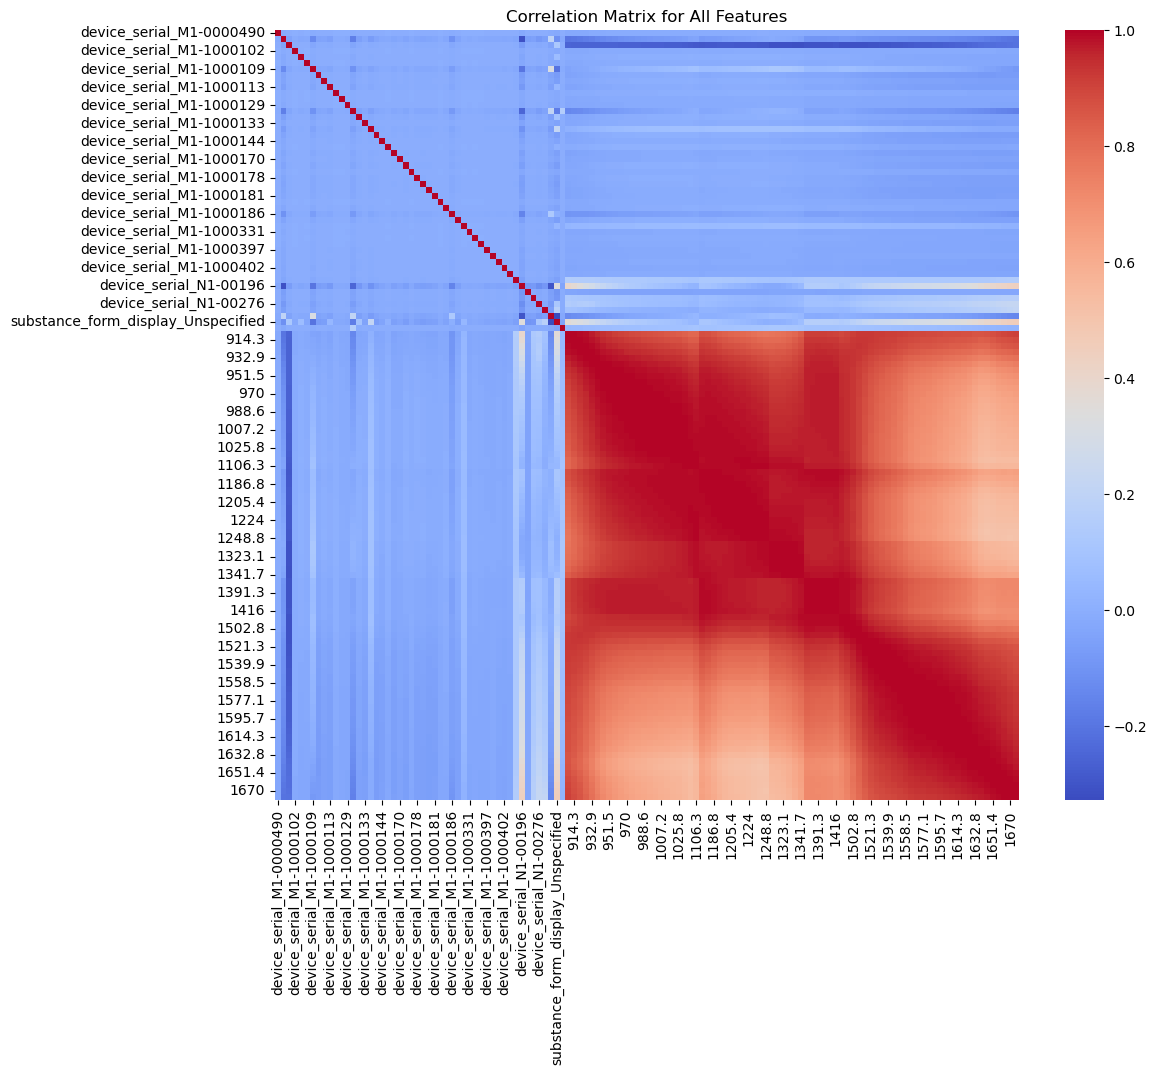

Number of features before removing highly correlated features: 128
Number of features after removing highly correlated features: 116
Highly correlated features:
1001 and 1007.2: 0.9999021664382056
1007.2 and 1013.4: 0.999901600242954
1013.4 and 1019.6: 0.9999118825427665
1019.6 and 1025.8: 0.9999224926517788
1310.7 and 1316.9: 0.9999842618577881
1316.9 and 1323.1: 0.9999592244747539
1385.1 and 1391.3: 0.9999349286097221
1391.3 and 1397.5: 0.9999760738493302
1397.5 and 1403.6: 0.999940049337064
1570.9 and 1577.1: 0.9999245562422839
1577.1 and 1583.3: 0.9999457076312125
1583.3 and 1589.5: 0.9999025399918398
Shape of OG train data: (1300, 131)
Shape of OG test data: (608, 130)
Shape of train data: (1300, 117)
Shape of test data: (608, 117)
Shape of y_train: (1300,)


: 

In [ ]:
def neural_network():
    
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_correlation=True, apply_scaling=True, apply_remove_outliers=False, apply_variance_threshold=False, apply_random_forest=True)
    
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    y_train_std = StandardScaler().fit(y_train.values.reshape(-1, 1))
    
    # Standardize y_train
    y_train_nn = y_train_std.transform(y_train.values.reshape(-1, 1))

        
    X_train, y_train_nn, X_test = map(
        lambda array: torch.tensor(array, dtype=torch.float32),
        [X_train.values, y_train_nn, X_test.values]
    )  
    
    training_dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train_nn),
        batch_size = 32,
        shuffle = True,
    )
    
    class NeuralNet1(torch.nn.Module):
        def __init__(self):
            super(NeuralNet1, self).__init__()
            self.layers = torch.nn.Sequential(
                torch.nn.Linear(X_train.shape[1], 64),
                torch.nn.Dropout(0.5),
                torch.nn.ReLU(),
                torch.nn.Linear(64, 1),
            )
        def forward(self, x):
            return self.layers(x)
    
    epochs = 100
    
    model = NeuralNet1()
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
    
    model.train()
    for epoch in tqdm.tqdm(range(epochs)):
        for data, target in training_dataloader:
            optimizer.zero_grad()
            pred = model(data)
            loss = torch.sqrt(loss_func(pred, target))
            loss.backward()
            optimizer.step()
            
    # Evaluation
    with torch.no_grad():
        model.eval()
        train_preds = y_train_std.inverse_transform(model(X_train).detach().numpy())
        train_gt = y_train_std.inverse_transform(y_train_nn.detach().numpy())
        train_loss = np.sqrt(mean_squared_error(train_preds, train_gt))

        test_preds = y_train_std.inverse_transform(model(X_test).detach().numpy())

    print(f'{train_loss=}')
    submission = submission_file(test_preds.squeeze())
    submission.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/sample_submission_NN.csv', index=False)
    print('Submission file saved successfully.')
        
     
def main():
    neural_network()
   
if __name__ == '__main__':
    main() 
    